In [45]:
!pip install airportsdata pycountry
!pip install haversine

In [46]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import airportsdata
from haversine import haversine, Unit

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Load the dataset

In [47]:
df_sessions_base= pd.read_csv('travel_tide_dataset.csv')
df_sessions_base.head()

,session_id,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,...,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,hotel_location,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,491617-feb5c48e5f874e708602706d4ea74d51,491617,1970-10-12,F,False,False,canada,hamilton,YHM,43.173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,499366-8b81f36216b34894be8838fb224ac162,499366,1976-01-04,F,False,False,canada,quebec,YQB,46.788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510094-b55030adcc7e49afbef15304ea4d2167,510094,1978-07-08,F,False,False,usa,long beach,LGB,33.818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,513322-ba930ad2186d4169bc51f5c11af0ccdd,513322,1973-01-04,F,False,False,usa,new york,LGA,40.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,521295-3c53ea4d476e4057b2460b011f44722b,521295,1983-03-08,F,False,True,usa,baton rouge,BTR,30.533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
df_sessions_base.shape

(49211, 42)

In [49]:
# Get the IDs of canceled trips
df_canceled_trips = df_sessions_base[df_sessions_base['cancellation'] == True]['trip_id'].drop_duplicates()
df_canceled_trips.head()

,trip_id
7351,513807-3c80157290d341feac1def60567b019c
11347,454934-2b0809d98c0a466ab8f1502d8c229ffc
13465,498500-8625a588e269412d9c6ac9ddbbb19a9d
15548,520861-df209855e39a4b3c93cc547763a87ea2
15549,733654-777d480b8d09486189720f37e154f60c


In [50]:
# Create a table for only booked trips
df_booked_trips = df_sessions_base[~df_sessions_base['trip_id'].isin(df_canceled_trips)]
df_booked_trips.head()

,session_id,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,...,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,hotel_location,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
0,491617-feb5c48e5f874e708602706d4ea74d51,491617,1970-10-12,F,False,False,canada,hamilton,YHM,43.173,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,499366-8b81f36216b34894be8838fb224ac162,499366,1976-01-04,F,False,False,canada,quebec,YQB,46.788,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,510094-b55030adcc7e49afbef15304ea4d2167,510094,1978-07-08,F,False,False,usa,long beach,LGB,33.818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,513322-ba930ad2186d4169bc51f5c11af0ccdd,513322,1973-01-04,F,False,False,usa,new york,LGA,40.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,521295-3c53ea4d476e4057b2460b011f44722b,521295,1983-03-08,F,False,True,usa,baton rouge,BTR,30.533,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
df_booked_trips.shape

(47998, 42)

# EDA on Session level

In [52]:
df_booked_trips.shape

(47998, 42)

In [53]:
df_booked_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47998 entries, 0 to 49210
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               47998 non-null  object 
 1   user_id                  47998 non-null  int64  
 2   birthdate                47998 non-null  object 
 3   gender                   47998 non-null  object 
 4   married                  47998 non-null  bool   
 5   has_children             47998 non-null  bool   
 6   home_country             47998 non-null  object 
 7   home_city                47998 non-null  object 
 8   home_airport             47998 non-null  object 
 9   home_airport_lat         47998 non-null  float64
 10  home_airport_lon         47998 non-null  float64
 11  sign_up_date             47998 non-null  object 
 12  trip_id                  15489 non-null  object 
 13  session_start            47998 non-null  object 
 14  session_end              47

In [54]:
df_booked_trips['home_country'].value_counts()

,count
home_country,
usa,39991
canada,8007


## Anomaly detection

In [55]:
df_booked_trips.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,47998.0,545394.154006,64164.528789,23557.000,517169.750,540260.000,573719.000,844489.000
home_airport_lat,47998.0,38.416751,6.183617,21.316,33.818,39.103,42.238,61.251
home_airport_lon,47998.0,-94.182541,18.052939,-157.927,-112.383,-90.035,-79.370,-63.499
flight_discount_amount,8189.0,0.139871,0.083864,0.050,0.100,0.100,0.200,0.600
hotel_discount_amount,6118.0,0.112365,0.062281,0.050,0.050,0.100,0.150,0.450
page_clicks,47998.0,15.471207,12.954254,1.000,6.000,12.000,21.000,279.000
seats,13157.0,1.183324,0.519154,1.000,1.000,1.000,1.000,8.000
checked_bags,13157.0,0.571179,0.635464,0.000,0.000,1.000,1.000,8.000
destination_airport_lat,13157.0,38.800186,6.254131,-37.008,33.942,39.872,42.364,55.972
destination_airport_lon,13157.0,-92.239693,23.645144,-157.927,-112.383,-87.752,-75.669,174.792


**We can see some -ve values in nights.** This is an anomaly and needs to be handled. The -ve value in destination_airport_lon is acceptable.

We also see an unusual page_click max amount (111). This needs to be investigated further.

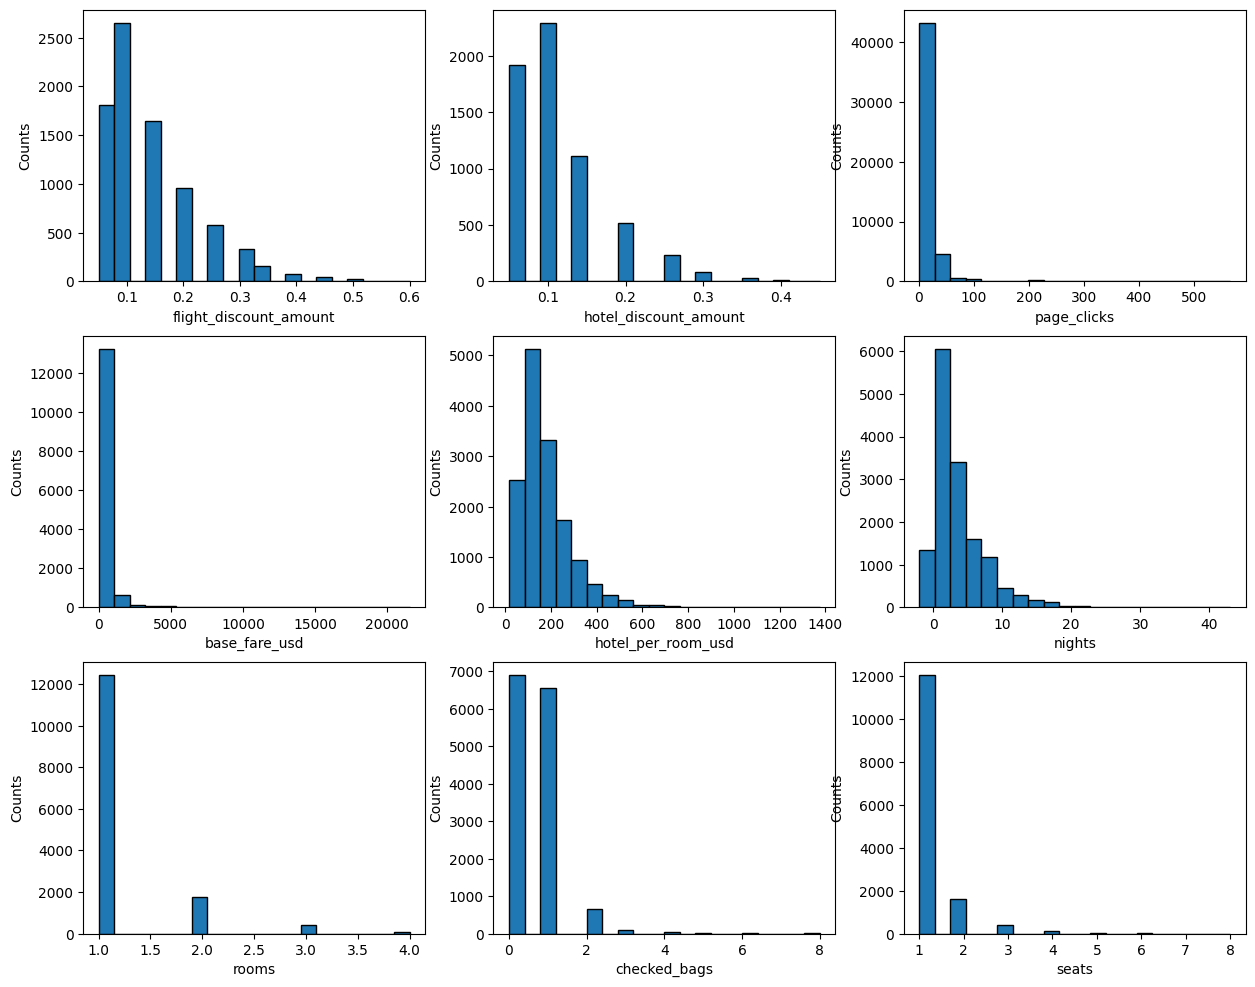

In [56]:
numerical_cols = ['flight_discount_amount', 'hotel_discount_amount', 'page_clicks', 'base_fare_usd', 'hotel_per_room_usd', 'nights', 'rooms', 'checked_bags', 'seats']


fig, axs = plt.subplots(3, 3, figsize=(15, 12))
axs = axs.flatten()

# Plot histograms for each column
for i, col in enumerate(numerical_cols):
    axs[i].hist(df_sessions_base[col], bins=20, edgecolor='black')
    axs[i].set_xlabel(col)
    axs[i].set_ylabel('Counts')

Clearly there are some outliers in the numerical data as the histograms as skewed.

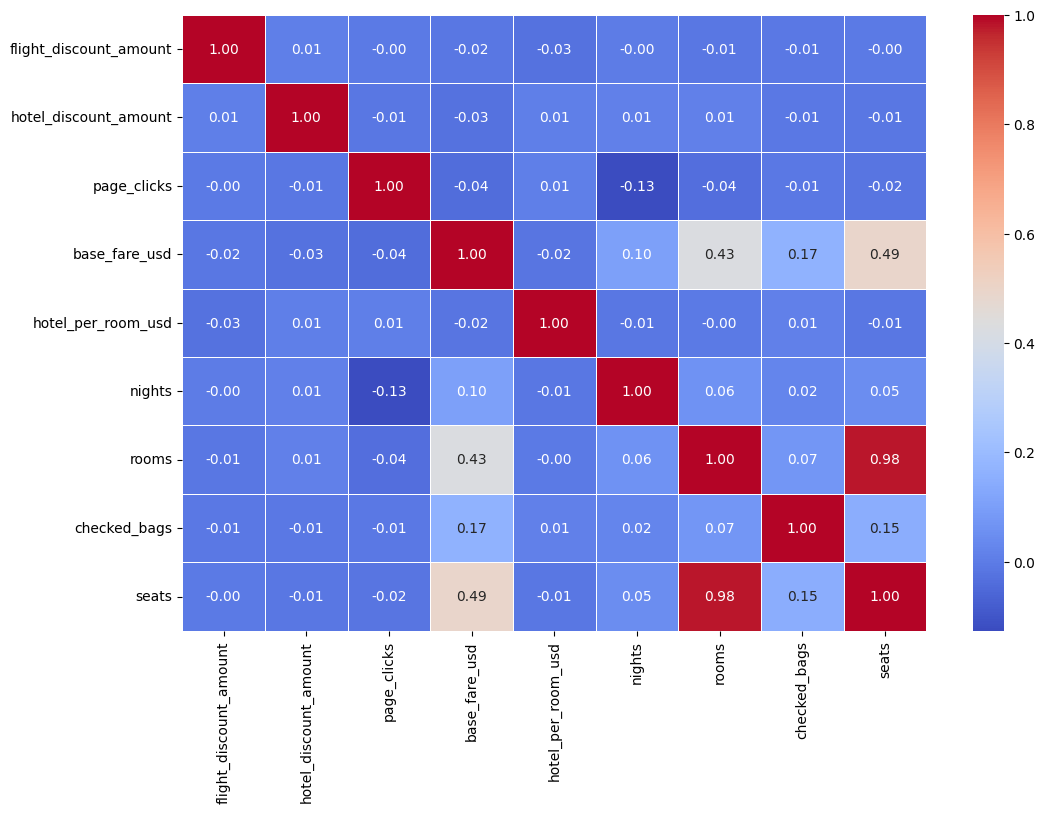

In [57]:
corr_matrix = df_booked_trips[numerical_cols].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f",linewidths=0.5)
plt.show()

No unusual correlation noticed. Rooms and seats are highly correlated. This is acceptable as more people travelling will need more rooms.

# Data cleaning

In [58]:
# Find out how many -ve nigh values are there in the dataset
neg_nights = df_booked_trips[df_booked_trips['nights'] < 0]['nights'].value_counts()
print(neg_nights)

nights
-1.0    102
-2.0      1
Name: count, dtype: int64


In [59]:
# Convert the -ve values to +ve
df_booked_trips["nights"] = df_booked_trips["nights"].abs()

<ipython-input-59-5950169dda5b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booked_trips["nights"] = df_booked_trips["nights"].abs()


Since the number of -ve nights are very low, we are assuming that this is a data error. So, we are converting these -ve values to +ve values.

In [60]:
# Checking if the data is now +ve
df_booked_trips[df_booked_trips['nights'] < 0]['nights'].value_counts()

,count
nights,


In [61]:
# Check null values
df_booked_trips.isna().sum()

,0
session_id,0
user_id,0
birthdate,0
gender,0
married,0
has_children,0
home_country,0
home_city,0
home_airport,0
home_airport_lat,0


In [62]:
df_booked_trips = df_booked_trips.dropna()

The null values can be dropped aas the % with total data is very low (<10%)

In [63]:
# Check if null values are removed.
df_booked_trips.isna().sum()

,0
session_id,0
user_id,0
birthdate,0
gender,0
married,0
has_children,0
home_country,0
home_city,0
home_airport,0
home_airport_lat,0


# Feature Engineering

In [64]:
bool_columns = df_booked_trips.select_dtypes(include='bool').columns.tolist()
#df_sessions.select_dtypes('bool')
bool_columns.append('return_flight_booked')
bool_columns

['married',
 'has_children',
 'flight_discount',
 'hotel_discount',
 'flight_booked',
 'hotel_booked',
 'cancellation',
 'return_flight_booked']

In [65]:
#Changing the True & False values to 1 & 0 for applying Machine Learning

for bool_column in bool_columns:
  df_booked_trips[bool_column] = df_booked_trips[bool_column].astype(int)

df_booked_trips.head(10)

<ipython-input-65-e3ceddcfdb7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booked_trips[bool_column] = df_booked_trips[bool_column].astype(int)
<ipython-input-65-e3ceddcfdb7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_booked_trips[bool_column] = df_booked_trips[bool_column].astype(int)
<ipython-input-65-e3ceddcfdb7d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the

,session_id,user_id,birthdate,gender,married,has_children,home_country,home_city,home_airport,home_airport_lat,...,destination_airport_lat,destination_airport_lon,base_fare_usd,hotel_name,hotel_location,nights,rooms,check_in_time,check_out_time,hotel_per_room_usd
7699,559846-132c0f926d3d4b26b7dae893573eb4c7,559846,1966-10-20,F,1,1,usa,los angeles,LAX,33.942,...,39.872,-75.241,728.52,Starwood,philadelphia,4.0,1.0,2023-02-05 14:49:13.53,2023-02-10 11:00:00,391.0
11653,506675-843c60b9d34c413da6f59ffaa3c6ae2d,506675,1975-11-14,F,0,1,usa,detroit,DTW,42.212,...,32.847,-96.852,283.05,Aman Resorts,dallas,10.0,1.0,2023-01-31 13:58:21.135,2023-02-11 11:00:00,151.0
31740,569829-955177c575204b81ab07ec3542d9debd,569829,1984-10-05,F,1,0,usa,chicago,ORD,41.979,...,38.852,-77.037,185.10,Crowne Plaza,washington,1.0,1.0,2023-07-06 10:13:41.835,2023-07-07 11:00:00,475.0
32759,521295-ad5aa98b3b7949608b29fd31f4903d56,521295,1983-03-08,F,0,1,usa,baton rouge,BTR,30.533,...,32.699,-117.215,478.05,Wyndham,san diego,3.0,1.0,2023-03-22 17:05:31.785,2023-03-26 11:00:00,170.0
32782,534105-4d63a1380dc640c4b0c0a28824bbbb84,534105,1972-11-12,F,0,0,usa,tucson,TUS,32.116,...,53.667,-113.467,876.51,Shangri,La,1.0,2.0,2023-03-08 21:00:21.6,2023-03-10 11:00:00,122.0
32844,531568-fa85634e530a478281cc8e86eaf8d3cf,531568,1983-03-08,F,0,0,usa,austin,AUS,30.194,...,33.942,-118.408,383.19,Shangri,La,2.0,1.0,2023-02-10 15:29:34.575,2023-02-13 11:00:00,155.0
32930,522607-abc322d8f7f940bf9e9f56222adfa840,522607,1979-06-19,F,1,0,usa,miami,MIA,25.793,...,30.194,-97.670,326.82,Conrad,austin,4.0,1.0,2023-01-19 11:12:58.545,2023-01-23 11:00:00,322.0
32947,527452-d12fefeafee64f548b01ee58be1461cb,527452,1980-12-26,M,0,0,usa,new orleans,MSY,29.993,...,40.640,-73.779,313.98,Choice Hotels,new york,4.0,1.0,2023-03-07 20:22:36.84,2023-03-12 11:00:00,97.0
32982,516375-4c907356f56c416a98f5fe054deddb0e,516375,1985-12-09,F,1,0,usa,houston,IAH,29.980,...,33.942,-118.408,434.80,Hyatt,los angeles,2.0,1.0,2023-04-11 12:46:09.03,2023-04-14 11:00:00,175.0
33056,512099-4b412e5fbe38495fb2840844a8e9a330,512099,1988-11-10,F,0,0,usa,fresno,FAT,36.776,...,39.872,-75.241,748.52,Hyatt,philadelphia,3.0,1.0,2023-02-25 14:49:08.265,2023-03-01 11:00:00,131.0


In [66]:
df_booked_trips.info()

<class 'pandas.core.frame.DataFrame'>
Index: 235 entries, 7699 to 49018
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   session_id               235 non-null    object 
 1   user_id                  235 non-null    int64  
 2   birthdate                235 non-null    object 
 3   gender                   235 non-null    object 
 4   married                  235 non-null    int64  
 5   has_children             235 non-null    int64  
 6   home_country             235 non-null    object 
 7   home_city                235 non-null    object 
 8   home_airport             235 non-null    object 
 9   home_airport_lat         235 non-null    float64
 10  home_airport_lon         235 non-null    float64
 11  sign_up_date             235 non-null    object 
 12  trip_id                  235 non-null    object 
 13  session_start            235 non-null    object 
 14  session_end              2

In [67]:
df_booked_trips['home_country'].value_counts()

,count
home_country,
usa,196
canada,39


In [68]:
# Load airport data
airports = airportsdata.load("IATA")  # Load IATA airport data

# Function to get country from airport code
def get_country(airport_code):
    if pd.notnull(airport_code) and airport_code in airports:
        return airports[airport_code]['country']
    return np.nan

# Add home and destination country
df_booked_trips['source_country'] = df_booked_trips['home_airport'].apply(get_country)
df_booked_trips['destination_country'] = df_booked_trips['destination_airport'].apply(get_country)

# Function to classify trip type
def classify_trip(row):
    if pd.notnull(row['source_country']) and pd.notnull(row['destination_country']):
        return "Domestic" if row['source_country'].lower() == row['destination_country'].lower() else "International"
    return np.nan

# Apply trip classification
df_booked_trips['trip_type'] = df_booked_trips.apply(classify_trip, axis=1)

# Convert necessary date columns to datetime
date_cols = ['session_start', 'session_end', 'sign_up_date', 'departure_time', 'check_in_time', 'return_time', 'birthdate']
for col in date_cols:
    df_booked_trips[col] = pd.to_datetime(df_booked_trips[col], errors='coerce')

current_date = datetime.now()

# Function to calculate Haversine distance
def calculate_haversine(row):
    if pd.notnull(row['home_airport_lat']) and pd.notnull(row['destination_airport_lat']):
        origin = (row['home_airport_lat'], row['home_airport_lon'])
        destination = (row['destination_airport_lat'], row['destination_airport_lon'])
        return haversine(origin, destination, unit=Unit.KILOMETERS)  # Distance in KM
    return np.nan

# Apply the Haversine formula for each trip
df_booked_trips['flight_distance_km'] = df_booked_trips.apply(calculate_haversine, axis=1)


In [69]:
# Aggregation at user_id level
df_user_features = df_booked_trips.groupby('user_id').agg(

    # ++++ User attributes ++++
    gender = ('gender', 'first'),
    married = ('married', 'first'),
    has_children = ('has_children', 'first'),
    home_country = ('home_country', 'first'),
    #home_city = ('home_city', 'first'),
    sign_up_date = ('sign_up_date', 'first'),
    age = ('birthdate', lambda x: (current_date - x.max()).days // 365),  # Age from birthdate

    # ++++ User browsing pattern ++++

    total_sessions = ('session_id', 'count'),
    #total_page_clicks=('page_clicks', 'sum'),
    total_page_clicks = ('page_clicks', 'sum'),
    #total_session_time=('session_end', lambda x: (x.max() - x.min()).total_seconds()),  # Time spent across sessions
    avg_session_duration = ('session_end', lambda x: (x - df_booked_trips.loc[x.index, 'session_start']).dt.total_seconds().mean()),
    #first_session_date=('session_start', 'min'),
    last_session_date=('session_start', 'max'),
    #days_since_last_session = ('session_start', lambda x: (current_date - x.max()).days),
    #browsed_airlines = ('trip_airline', 'nunique'),
    #browsed_hotels = ('hotel_name', 'nunique'),
    #browsed_destinations = ('destination_airport', 'nunique'),



    # ++++ User booking pattern ++++

    total_trips = ('trip_id', 'count'),
    total_flights_booked = ('flight_booked', 'sum'),
    total_hotels_booked = ('hotel_booked', 'sum'),
    total_spent_flights = ('base_fare_usd', 'sum'),
    total_spent_hotels = ('hotel_per_room_usd', lambda x: (x * df_booked_trips.loc[x.index, 'nights']).sum()),
    #avg_flight_spending = ('base_fare_usd', 'mean'),
    #avg_hotel_spending = ('hotel_per_room_usd', 'mean'),
    discount_used_flight = ('flight_discount_amount', lambda x: (x > 0).sum()),
    discount_used_hotel = ('hotel_discount_amount', lambda x: (x > 0).sum()),
    #most_used_airline=('trip_airline', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    #favourite_destination=('destination_country', lambda x: x.mode()[0] if not x.mode().empty else np.nan),
    avg_seats_booked=('seats', 'mean'),
    avg_checked_bags=('checked_bags', 'mean'),
    return_flights=('return_flight_booked', lambda x: x.notnull().sum()),
    avg_days_to_departure=('departure_time', lambda x: (x - df_booked_trips.loc[x.index, 'session_end']).dt.days.mean()),
    avg_days_to_check_in=('check_in_time', lambda x: (x - df_booked_trips.loc[x.index, 'session_end']).dt.days.mean()),
    avg_flight_distance=('flight_distance_km', 'mean'),  # Average distance flown
    domestic_trips=('trip_type', lambda x: (x == "Domestic").sum()),
    international_trips=('trip_type', lambda x: (x == "International").sum()),
)



# Additional derived features
df_user_features['total_spent'] = df_user_features['total_spent_flights'] + df_user_features['total_spent_hotels']
df_user_features['booking_frequency'] = df_user_features['total_flights_booked'] + df_user_features['total_hotels_booked']
df_user_features['avg_spent_per_booking'] = df_user_features['total_spent'] / df_user_features['booking_frequency']
df_user_features['session_recency'] = (current_date - df_user_features['last_session_date']).dt.days

# Drop redundant date columns after computation
df_user_features = df_user_features.drop(columns=['last_session_date', 'sign_up_date'])

# Reset index to make user_id a column
df_user_features.reset_index(inplace=True)

# Final cleaned DataFrame with engineered features
df_user_features.head()

,user_id,gender,married,has_children,home_country,age,total_sessions,total_page_clicks,avg_session_duration,total_trips,...,return_flights,avg_days_to_departure,avg_days_to_check_in,avg_flight_distance,domestic_trips,international_trips,total_spent,booking_frequency,avg_spent_per_booking,session_recency
0,402332,F,0,0,usa,33,1,22,161.0,1,...,1,16.0,16.0,3521.505201,0,1,732.24,2,366.120,730
1,417679,F,0,0,usa,38,1,21,156.0,1,...,1,6.0,6.0,4141.061788,1,0,1010.39,2,505.195,726
2,418329,M,0,1,usa,50,1,21,154.0,1,...,1,7.0,7.0,841.267470,0,1,2291.55,2,1145.775,578
3,425953,F,1,0,usa,38,1,26,195.0,1,...,1,17.0,17.0,636.382653,1,0,528.23,2,264.115,772
4,427506,F,1,1,usa,55,1,20,149.0,1,...,1,8.0,8.0,466.419926,1,0,297.90,2,148.950,697


In [70]:
df_user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233 entries, 0 to 232
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                233 non-null    int64  
 1   gender                 233 non-null    object 
 2   married                233 non-null    int64  
 3   has_children           233 non-null    int64  
 4   home_country           233 non-null    object 
 5   age                    233 non-null    int64  
 6   total_sessions         233 non-null    int64  
 7   total_page_clicks      233 non-null    int64  
 8   avg_session_duration   233 non-null    float64
 9   total_trips            233 non-null    int64  
 10  total_flights_booked   233 non-null    int64  
 11  total_hotels_booked    233 non-null    int64  
 12  total_spent_flights    233 non-null    float64
 13  total_spent_hotels     233 non-null    float64
 14  discount_used_flight   233 non-null    int64  
 15  discou

In [71]:
final_features = df_user_features[['user_id', 'gender', 'has_children',
                                   'age', 'total_trips', 'total_spent_flights',
                                   'total_spent_hotels', 'avg_checked_bags',
                                   'avg_flight_distance', 'domestic_trips',
                                   'international_trips', 'booking_frequency',
                                   'session_recency']]

final_features = final_features.set_index('user_id')
final_features.head()

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
user_id,,,,,,,,,,,,
402332,F,0,33,1,623.24,109.0,0.0,3521.505201,0,1,2,730
417679,F,0,38,1,780.39,230.0,1.0,4141.061788,1,0,2,726
418329,M,1,50,1,149.55,2142.0,1.0,841.267470,0,1,2,578
425953,F,0,38,1,327.23,201.0,0.0,636.382653,1,0,2,772
427506,F,1,55,1,89.90,208.0,0.0,466.419926,1,0,2,697


In [72]:
final_features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 233 entries, 402332 to 732729
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               233 non-null    object 
 1   has_children         233 non-null    int64  
 2   age                  233 non-null    int64  
 3   total_trips          233 non-null    int64  
 4   total_spent_flights  233 non-null    float64
 5   total_spent_hotels   233 non-null    float64
 6   avg_checked_bags     233 non-null    float64
 7   avg_flight_distance  233 non-null    float64
 8   domestic_trips       233 non-null    int64  
 9   international_trips  233 non-null    int64  
 10  booking_frequency    233 non-null    int64  
 11  session_recency      233 non-null    int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 23.7+ KB


In [73]:
final_features['gender'].value_counts()

,count
gender,
F,204
M,29


In [74]:
gender_map = {'F': 0,
              'M': 1}

final_features['gender'] = final_features['gender'].map(gender_map)

In [75]:
final_features['gender'].value_counts()

,count
gender,
0,204
1,29


In [76]:
final_features.head()

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
user_id,,,,,,,,,,,,
402332,0,0,33,1,623.24,109.0,0.0,3521.505201,0,1,2,730
417679,0,0,38,1,780.39,230.0,1.0,4141.061788,1,0,2,726
418329,1,1,50,1,149.55,2142.0,1.0,841.267470,0,1,2,578
425953,0,0,38,1,327.23,201.0,0.0,636.382653,1,0,2,772
427506,0,1,55,1,89.90,208.0,0.0,466.419926,1,0,2,697


In [77]:
final_features.isna().sum()

,0
gender,0
has_children,0
age,0
total_trips,0
total_spent_flights,0
total_spent_hotels,0
avg_checked_bags,0
avg_flight_distance,0
domestic_trips,0
international_trips,0


In [78]:
final_features.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,233.0,0.124464,0.330820,0.000000,0.000000,0.000000,0.000000,1.000000
has_children,233.0,0.304721,0.461280,0.000000,0.000000,0.000000,1.000000,1.000000
age,233.0,42.935622,9.586277,18.000000,38.000000,43.000000,50.000000,68.000000
total_trips,233.0,1.008584,0.092448,1.000000,1.000000,1.000000,1.000000,2.000000
total_spent_flights,233.0,449.148369,294.757953,22.590000,232.130000,426.250000,615.690000,2198.610000
total_spent_hotels,233.0,522.806867,716.885915,0.000000,177.000000,355.000000,646.000000,7446.000000
avg_checked_bags,233.0,0.549356,0.662032,0.000000,0.000000,0.000000,1.000000,3.000000
avg_flight_distance,233.0,2178.223660,1178.554370,129.638366,1241.258272,2124.437163,3089.990566,6099.142935
domestic_trips,233.0,0.648069,0.487524,0.000000,0.000000,1.000000,1.000000,2.000000
international_trips,233.0,0.309013,0.463081,0.000000,0.000000,0.000000,1.000000,1.000000


In [79]:
final_features.shape

(233, 12)

# Clustering

In [80]:
# Scaled the user features for ML
scaler = StandardScaler()
feature_scaled = scaler.fit_transform(final_features)

In [81]:
feature_scaled.shape

(233, 12)

In [82]:
feature_scaled = pd.DataFrame(feature_scaled)
feature_scaled.index = final_features.index
feature_scaled.columns = final_features.columns
feature_scaled.shape

(233, 12)

In [83]:
feature_scaled.head()

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
user_id,,,,,,,,,,,,
402332,-0.377037,-0.662021,-1.038674,-0.093048,0.591897,-0.578471,-0.831590,1.142224,-1.332169,1.495363,-0.093048,0.649518
417679,-0.377037,-0.662021,-0.515972,-0.093048,1.126194,-0.409322,0.682163,1.669048,0.723429,-0.668734,-0.093048,0.572335
418329,2.652260,1.510526,0.738513,-0.093048,-1.018610,2.263511,0.682163,-1.136846,-1.332169,1.495363,-0.093048,-2.283458
425953,-0.377037,-0.662021,-0.515972,-0.093048,-0.414512,-0.449862,-0.831590,-1.311064,0.723429,-0.668734,-0.093048,1.459946
427506,-0.377037,1.510526,1.261214,-0.093048,-1.221415,-0.440076,-0.831590,-1.455587,0.723429,-0.668734,-0.093048,0.012754


In [84]:
feature_scaled.isna().sum()

,0
gender,0
has_children,0
age,0
total_trips,0
total_spent_flights,0
total_spent_hotels,0
avg_checked_bags,0
avg_flight_distance,0
domestic_trips,0
international_trips,0


In [85]:
feature_scaled.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,233.0,4.002521e-17,1.002153,-0.377037,-0.377037,-0.377037,-0.377037,2.652260
has_children,233.0,5.336694e-17,1.002153,-0.662021,-0.662021,-0.662021,1.510526,1.510526
age,233.0,-1.601008e-16,1.002153,-2.606779,-0.515972,0.006730,0.738513,2.620239
total_trips,233.0,5.412933e-16,1.002153,-0.093048,-0.093048,-0.093048,-0.093048,10.747093
total_spent_flights,233.0,-4.955502e-17,1.002153,-1.450263,-0.737845,-0.077853,0.566228,5.948026
total_spent_hotels,233.0,-3.811925e-17,1.002153,-0.730845,-0.483412,-0.234581,0.172215,9.678106
avg_checked_bags,233.0,3.049540e-17,1.002153,-0.831590,-0.831590,-0.831590,0.682163,3.709670
avg_flight_distance,233.0,1.372293e-16,1.002153,-1.741961,-0.796724,-0.045736,0.775297,3.334051
domestic_trips,233.0,1.715366e-17,1.002153,-1.332169,-1.332169,0.723429,0.723429,2.779027
international_trips,233.0,4.574309e-17,1.002153,-0.668734,-0.668734,-0.668734,1.495363,1.495363


In [86]:
# Dimensionality reduction using PCA

pca = PCA(n_components = 0.7)
pca.fit(feature_scaled)

component_matrix = pd.DataFrame(pca.components_).T
component_matrix.columns = [f"pca_{i}"for i in range(component_matrix.shape[1])]
component_matrix.index = feature_scaled.columns
component_matrix

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5
gender,-0.020066,-0.060771,-0.118023,-0.040654,0.206985,0.950464
has_children,-0.163604,-0.025216,0.129795,0.428029,0.349309,0.058635
age,-0.146894,0.022211,0.109958,0.631685,-0.156043,0.112846
total_trips,0.211670,0.638117,-0.103422,0.004285,0.120022,0.022894
total_spent_flights,-0.376759,0.308469,0.462312,-0.152671,-0.089781,0.051661
total_spent_hotels,-0.058132,0.144814,-0.255098,0.300470,-0.116770,-0.013876
avg_checked_bags,-0.004025,-0.107919,0.047146,-0.336507,0.689139,-0.115028
avg_flight_distance,-0.425052,0.185278,0.496022,-0.156594,-0.053301,0.072144
domestic_trips,0.538258,-0.006319,0.428463,0.084937,-0.018819,0.030374
international_trips,-0.488000,0.136360,-0.464927,-0.083400,0.032929,-0.100261


<Axes: >

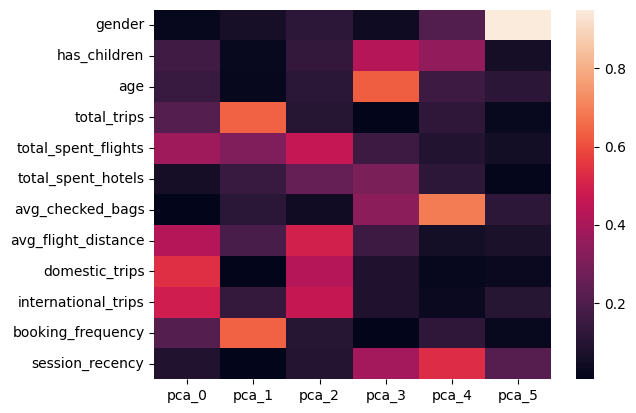

In [87]:
sns.heatmap(np.abs(component_matrix))

In [88]:
customers_pca = pca.fit_transform(feature_scaled)
customers_pca

array([[-1.94650717,  0.50529603, -0.39244618, -1.07399439, -0.37043148,
        -0.6333723 ],
       [-0.29511893,  0.33296979,  2.08117418, -1.04131323,  0.34452289,
        -0.38908327],
       [-0.9610983 , -0.34238723, -3.07844988,  0.66464832,  0.16054954,
         2.7493217 ],
       ...,
       [ 1.34206632, -0.54427168, -0.35881663,  0.78901056,  0.02700204,
        -0.33102726],
       [-0.90836817, -0.07554778, -1.66271953, -2.1126813 , -0.35757005,
        -0.49673195],
       [ 1.77967248, -0.90129886, -0.63063922,  0.90963446, -0.6323096 ,
         0.01479476]])

In [89]:
customers_pca = pd.DataFrame(customers_pca)
customers_pca.index = feature_scaled.index
customers_pca.columns = [f"pca_{i}"for i in range(customers_pca.shape[1])]
customers_pca

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5
user_id,,,,,,
402332,-1.946507,0.505296,-0.392446,-1.073994,-0.370431,-0.633372
417679,-0.295119,0.332970,2.081174,-1.041313,0.344523,-0.389083
418329,-0.961098,-0.342387,-3.078450,0.664648,0.160550,2.749322
425953,1.482280,-0.543782,-0.086441,0.502192,0.073833,-0.701673
427506,1.358201,-0.822216,-0.193056,2.141953,-0.132862,-0.111824
...,...,...,...,...,...,...
640580,1.693682,-0.717164,-0.580947,1.357129,-0.905448,-0.258409
664663,1.702847,-0.733785,-0.210028,-1.319989,0.127575,-0.485210
665892,1.342066,-0.544272,-0.358817,0.789011,0.027002,-0.331027


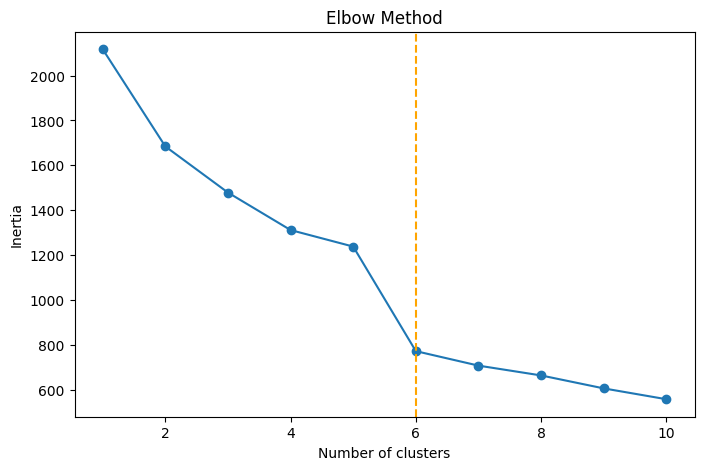

In [90]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(customers_pca)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method graph
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')


# Add a reference line to help identify the elbow point
plt.axvline(x=6, color='orange', linestyle='--', label='Elbow Point')

plt.show()

In [91]:
# Choose the optimal number of clusters (e.g., 4)
optimal_k = 6

# Perform K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
final_features['cluster'] = kmeans.fit_predict(customers_pca)

In [92]:
# Check the model score

sil_score = silhouette_score(customers_pca, final_features['cluster'] )  # Measure clustering quality
print(f"Silhouette Score: {sil_score}")

Silhouette Score: 0.26033247104304996


In [93]:
final_features['cluster'].value_counts()

,count
cluster,
0,82
2,55
4,36
3,30
1,28
5,2


In [94]:
customers_viz = pd.concat([customers_pca,final_features['cluster']],axis=1)
customers_viz

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,cluster
user_id,,,,,,,
402332,-1.946507,0.505296,-0.392446,-1.073994,-0.370431,-0.633372,4
417679,-0.295119,0.332970,2.081174,-1.041313,0.344523,-0.389083,2
418329,-0.961098,-0.342387,-3.078450,0.664648,0.160550,2.749322,1
425953,1.482280,-0.543782,-0.086441,0.502192,0.073833,-0.701673,0
427506,1.358201,-0.822216,-0.193056,2.141953,-0.132862,-0.111824,0
...,...,...,...,...,...,...,...
640580,1.693682,-0.717164,-0.580947,1.357129,-0.905448,-0.258409,0
664663,1.702847,-0.733785,-0.210028,-1.319989,0.127575,-0.485210,0
665892,1.342066,-0.544272,-0.358817,0.789011,0.027002,-0.331027,0


<Axes: xlabel='pca_0', ylabel='pca_1'>

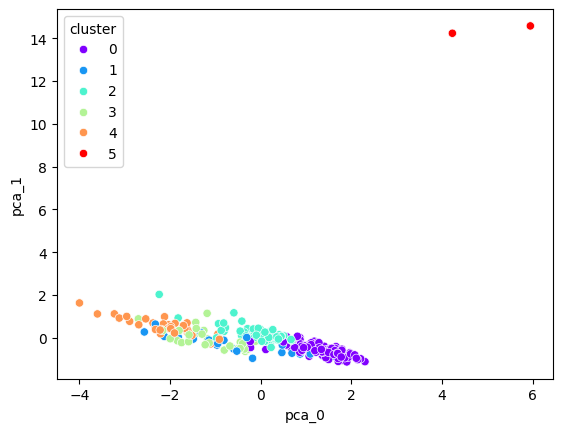

In [95]:
sns.scatterplot(data=customers_viz,x="pca_0",y="pca_1",hue=final_features['cluster'],palette="rainbow",legend='full')

In [96]:
# Analyze clusters by computing average values
cluster_analysis = final_features.groupby('cluster').mean()
cluster_analysis

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency
cluster,,,,,,,,,,,,
0,0.000000,0.256098,41.548780,1.0,234.374390,413.207317,0.500000,1194.622206,0.963415,0.000000,2.0,690.780488
1,1.000000,0.321429,41.892857,1.0,385.052857,546.785714,0.607143,1963.520812,0.535714,0.321429,2.0,693.928571
2,0.018182,0.345455,44.909091,1.0,680.657818,444.563636,0.618182,3295.405128,0.981818,0.000000,2.0,706.618182
3,0.000000,0.366667,46.400000,1.0,318.025667,970.533333,0.533333,1727.869418,0.000000,0.933333,2.0,708.500000
4,0.000000,0.305556,41.222222,1.0,721.278056,453.416667,0.555556,3282.307833,0.000000,0.944444,2.0,685.888889
5,0.000000,0.000000,39.000000,2.0,854.215000,1365.500000,0.000000,1671.031264,1.500000,0.500000,4.0,681.000000


# Perk Recommendation to clusters

In [102]:
def assign_cluster_perks(cluster_row):
    perks = []

    # Free Cancellation : International travelers face more uncertainty, so "Free Cancellation" is a useful perk.
    # But it is good to offer them to inactive users, so that they start booking more.
    if cluster_row['international_trips'] > 0.9 and cluster_row['session_recency'] > 700:
        return("Free Cancellation")

    # Free child ticket : If most users are over 30 and have children
    elif cluster_row['age'] > 40 and cluster_row['has_children'] > 0.5:
        return("Free child ticket")

    # Exclusive Discounts : These are customers with high booking frequency. Frequent travelers are loyal, so offering "Exclusive Discounts" encourages continued loyalty.
    elif cluster_row['booking_frequency'] > 2 :
        return("Exclusive Discounts")

    # Free hotel meal : Moderate spending on hotels and flights. These customers might appreciate a "Free Hotel Meal" as a mid-tier perk.
    elif cluster_row['total_spent_flights'] < 500 and cluster_row['total_spent_hotels'] < 500:
        return("Free hotel meal")

    # Free checked bags : These customers travel internationally and frequently check bags.
    elif cluster_row['avg_checked_bags'] > 0.5 and cluster_row['international_trips'] > 0.9:
        return("Free checked bags")

    # 1-night free :  These customers spend a lot on flights but not on hotels and have been inactive for quite some time,
    # so offering "One Night Free Hotel With Flight" perk can make them to book more hotels.
    elif cluster_row['total_spent_flights'] > 500 and cluster_row['total_spent_hotels'] < 500 and cluster_row['session_recency'] > 700:
        return("One Night Free Hotel With Flight")

    # 10% off next trip : For customers who do not fit any of the above conditions, a one time 10% off next trip can be offered
    else:
      return ("10% off next trip")

# Assign perks to each cluster
cluster_analysis['perks'] = cluster_analysis.apply(assign_cluster_perks, axis=1)

cluster_analysis

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency,perks
cluster,,,,,,,,,,,,,
0,0.000000,0.256098,41.548780,1.0,234.374390,413.207317,0.500000,1194.622206,0.963415,0.000000,2.0,690.780488,Free hotel meal
1,1.000000,0.321429,41.892857,1.0,385.052857,546.785714,0.607143,1963.520812,0.535714,0.321429,2.0,693.928571,10% off next trip
2,0.018182,0.345455,44.909091,1.0,680.657818,444.563636,0.618182,3295.405128,0.981818,0.000000,2.0,706.618182,One Night Free Hotel With Flight
3,0.000000,0.366667,46.400000,1.0,318.025667,970.533333,0.533333,1727.869418,0.000000,0.933333,2.0,708.500000,Free Cancellation
4,0.000000,0.305556,41.222222,1.0,721.278056,453.416667,0.555556,3282.307833,0.000000,0.944444,2.0,685.888889,Free checked bags
5,0.000000,0.000000,39.000000,2.0,854.215000,1365.500000,0.000000,1671.031264,1.500000,0.500000,4.0,681.000000,Exclusive Discounts


In [103]:
# Merge cluster perks into the main user dataframe
final_features = final_features.merge(cluster_analysis[['perks']], left_on='cluster', right_index=True, how='left')
final_features.head(10)

,gender,has_children,age,total_trips,total_spent_flights,total_spent_hotels,avg_checked_bags,avg_flight_distance,domestic_trips,international_trips,booking_frequency,session_recency,cluster,perks
user_id,,,,,,,,,,,,,,
402332,0,0,33,1,623.24,109.0,0.0,3521.505201,0,1,2,730,4,Free checked bags
417679,0,0,38,1,780.39,230.0,1.0,4141.061788,1,0,2,726,2,One Night Free Hotel With Flight
418329,1,1,50,1,149.55,2142.0,1.0,841.267470,0,1,2,578,1,10% off next trip
425953,0,0,38,1,327.23,201.0,0.0,636.382653,1,0,2,772,0,Free hotel meal
427506,0,1,55,1,89.90,208.0,0.0,466.419926,1,0,2,697,0,Free hotel meal
430722,1,0,29,1,192.93,632.0,1.0,1241.258272,1,0,2,661,1,10% off next trip
431602,0,0,38,1,693.02,0.0,1.0,3903.521080,1,0,2,762,2,One Night Free Hotel With Flight
434623,0,0,35,1,531.63,800.0,1.0,2980.657328,1,0,2,709,2,One Night Free Hotel With Flight
438985,0,0,30,1,554.03,186.0,1.0,3276.440591,0,1,2,659,4,Free checked bags


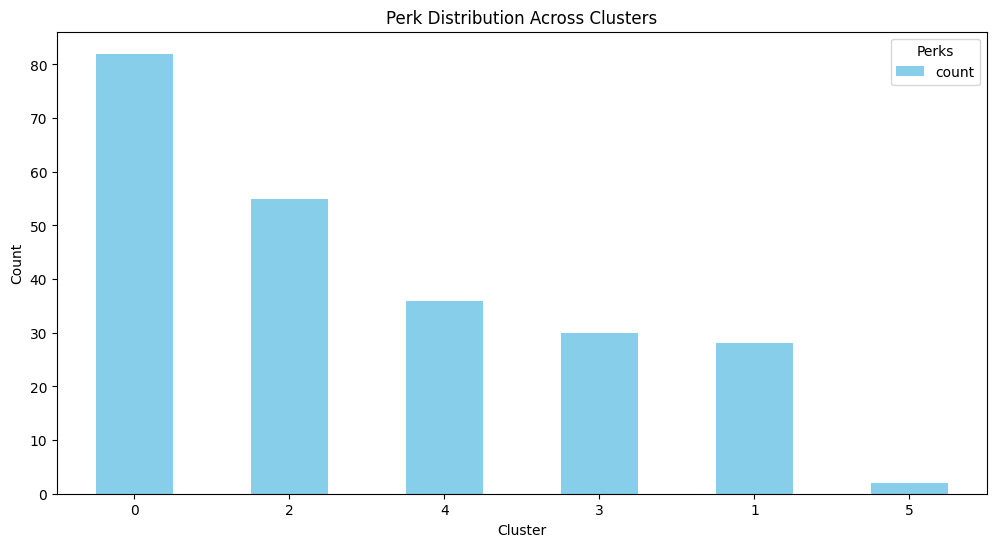

In [104]:
cluster_distribution = final_features['cluster'].value_counts()
# Plot stacked bar chart
cluster_distribution.plot(kind='bar', stacked=True, figsize=(12, 6), color='skyblue')

# Add labels and title
plt.title("Perk Distribution Across Clusters")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.legend(title="Perks", bbox_to_anchor=(1, 1))  # Move legend outside
plt.xticks(rotation=0)
plt.show()

In [105]:
# Display cluster-wise perk distribution
perks_distribution = final_features.groupby('cluster')['perks'].value_counts()
perks_distribution

,,count
cluster,perks,
0,Free hotel meal,82
1,10% off next trip,28
2,One Night Free Hotel With Flight,55
3,Free Cancellation,30
4,Free checked bags,36
5,Exclusive Discounts,2


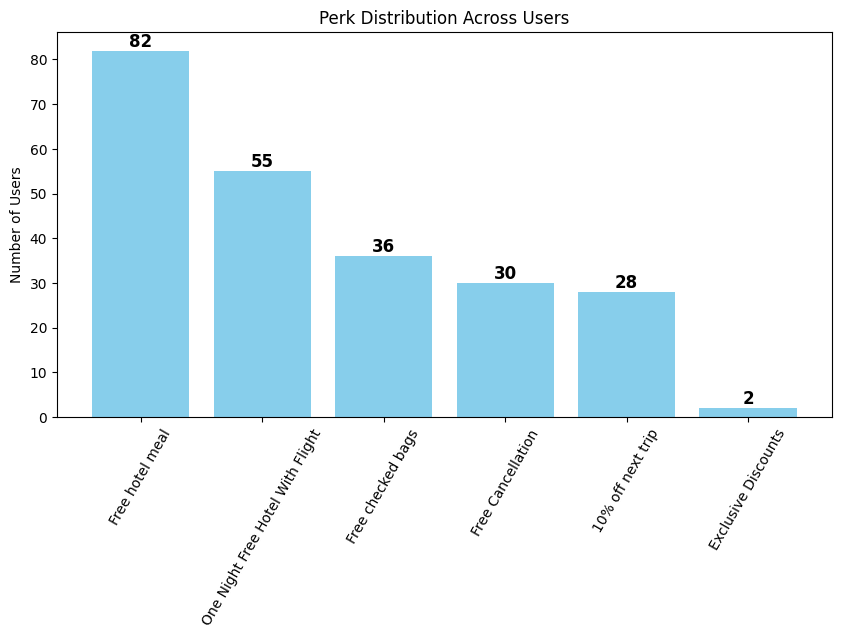

In [106]:
# Visualize the perks distribution across users
perk_counts = final_features['perks'].value_counts()

plt.figure(figsize=(10, 5))
bars = plt.bar(perk_counts.index, perk_counts.values, color='skyblue')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,   # X position (center of bar)
             bar.get_height(),                    # Y position (top of bar)
             int(bar.get_height()),               # Text (value count)
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title("Perk Distribution Across Users")
plt.ylabel("Number of Users")
plt.xticks(rotation=60)  # Rotate x-axis labels if needed
plt.show()

In [107]:
# Save the final dataset with perks
final_features.to_csv('travel_tide_dataset_with_perks.csv', index=False)